# Calibrating & Using a $\pi$-pulse

Once we know the frequency of our qubit, the next step is to determine the strength of a $\pi$-pulse. The desired rotation is such that the qubit goes from $|0\rangle$ to $|1\rangle$. We will change the drive amplitude `amp` in small increments and measuring the state of the qubit each time. We expect to see oscillations which are commonly named Rabi oscillations, as the qubit goes between its computational subspaces.

In [13]:
import numpy as np
GHz = 1.0e9

qubit = 0
rough_qubit_frequency = 4.96227839460659 * GHz

Here we create a circuit to host our Rabi schedules

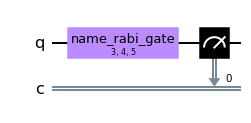

In [9]:
from qiskit import QuantumCircuit
from qiskit.circuit import Gate

rabi_circ = QuantumCircuit(1, 1)
cal_gate = Gate('name_rabi_gate', 1, [3,4,5])
rabi_circ.append(cal_gate, [qubit])
rabi_circ.measure(0, 0)

rabi_circ.draw('mpl', idle_wires=False)

In [10]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_manila')

backend_config = backend.configuration()
dt = backend_config.dt

ibmqfactory.load_account:WARNING:2022-05-06 10:03:59,505: Credentials are already in use. The existing account in the session will be replaced.


In [11]:
inst_sched_map_man = backend.defaults().instruction_schedule_map

qubit = 0 # qubit 0 on ibmq_manila (there are 5 of them)
x_man = inst_sched_map_man.get('x', qubits=[qubit])

x_man.instructions

((0,
  Play(Drag(duration=160, amp=(0.19587717637708868+0j), sigma=40, beta=-0.5598528148942019, name='Xp_d0'), DriveChannel(0), name='Xp_d0')),)

In [18]:
# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

from qiskit.pulse import DriveChannel, Play, Schedule
from copy import deepcopy
from qiskit import pulse
from qiskit.pulse.library import Drag

rabi_circs = [] # array of rabi_circs

for amp_off in drive_amps:
    rabi_circ_off = deepcopy(rabi_circ)
    with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
        with pulse.frequency_offset(rough_qubit_frequency, DriveChannel(qubit)):
            pulse.play(Drag(duration=160, 
                            amp=amp_off, 
                            sigma=40, 
                            beta=-0.5598528148942019, 
                            name='Rabi Pulse'), DriveChannel(qubit))
        rabi_circ_off.add_calibration(cal_gate, [qubit], rabi_sched)
    rabi_circs.append(rabi_circ_off)

In [20]:
len(rabi_circs) # 50 circuits will be sent corresponding to 50 rabi scheds ~ 50 amplitude offset.

50

In [22]:
rabi_circs[0].draw()

┌───────────────────────┐┌─┐
q_0: ┤ name_rabi_gate(3,4,5) ├┤M├
     └───────────────────────┘└╥┘
c: 1/══════════════════════════╩═
                               0

In [ ]:
from qiskit.tools.monitor import job_monitor

num_shots_per_amp = 1024

rabi_job = backend.run(rabi_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_amp)
job_monitor(rabi_job)
print(f"rabi oscillation job id: {rabi_job.job_id()}")

Job Status: job is queued (63)    

In [ ]:
rabi_results = rabi_job.result(timeout=120)
# rabi_results = backend.retrieve_job('6273f3459381703b163e72fc') 

In [ ]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [2, 0, 0.2, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [ ]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

with pulse.build(backend) as pi_pulse:
    drive_duration = 160
    drive_sigma = 40
    drive_chan = pulse.drive_channel(qubit)
    drive_beta = -0.5598528148942019
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_amp,
                              sigma=drive_sigma,
                              beta=drive_beta
                              name='pi_pulse'), drive_chan)